In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

df =pd.read_csv('../../data/options_additions_removals.csv')
# Identify non-removed variables
df['removed'] = df['commit_date_removed'].notna()
df_not_removed = df[~df['removed']]

print(len(df_not_removed))

3623


In [2]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Ensure the 'lifecycle_days' column is numeric
df['lifecycle_days'] = pd.to_numeric(df['lifecycle_days'], errors='coerce')

# Filter out removed toggles (i.e., those with a non-null 'lifecycle_days' value)
removed_toggles = df.dropna(subset=['lifecycle_days'])

# Calculate median lifespan for all removed toggles
median_lifespan = removed_toggles['lifecycle_days'].median()


# Calculate median lifespan for all removed toggles
max_lifespan = removed_toggles['lifecycle_days'].max()

# Group by toggle type and compute median lifespan per type
median_per_type = removed_toggles.groupby('toggle_type')['lifecycle_days'].median()

# Compute maximum lifespan per type
max_per_type = removed_toggles.groupby('toggle_type')['lifecycle_days'].max()

# Count toggles that were not removed
not_removed_count = df['lifecycle_days'].isna().sum()

# Total number of toggles added and removed
total_toggles = len(df)

# Count total toggles per type
total_per_type = df['toggle_type'].value_counts()

# Count not removed toggles per type
not_removed_per_type = df[df['lifecycle_days'].isna()]['toggle_type'].value_counts()

# Compute percentage of not removed toggles per type
not_removed_percentage = (not_removed_per_type / total_per_type) * 100

# Perform Mann-Whitney U test between Switches and UI Flags
switches_lifespans = removed_toggles[removed_toggles['toggle_type'] == 'Switches']['lifecycle_days']
ui_flags_lifespans = removed_toggles[removed_toggles['toggle_type'] == 'UI Flag']['lifecycle_days']
command_lifespans = removed_toggles[removed_toggles['toggle_type'] == 'Runtime Feature']['lifecycle_days']

# Mann-Whitney U test: Switches vs UI Flags
mannwhitney_switches_ui = mannwhitneyu(switches_lifespans, ui_flags_lifespans, alternative='two-sided')

# Mann-Whitney U test: Switches vs Runtime Features
mannwhitney_switches_runtime = mannwhitneyu(switches_lifespans, command_lifespans, alternative='two-sided')

mannwhitney_ui_runtime = mannwhitneyu(ui_flags_lifespans, command_lifespans, alternative='two-sided')

# Display results
analysis_results = {
    "Median lifespan (all removed toggles)": median_lifespan,
    "Max lifespan (all removed toggles)": max_lifespan,
    "Median lifespan per type": median_per_type.to_dict(),
    "Maximum lifespan per type": max_per_type.to_dict(),
    "Not removed toggles count": not_removed_count,
    "Total toggles added and removed": total_toggles,
    "Not removed toggles per type": not_removed_per_type.to_dict(),
    "Percentage of not removed toggles per type": not_removed_percentage.to_dict(),
    "Mann-Whitney U test (Switches vs UI Flags)": mannwhitney_switches_ui.pvalue,
    "Mann-Whitney U test (Switches vs Runtime Features)": mannwhitney_switches_runtime.pvalue,
    "Mann-Whitney U test (UI Flags vs Runtime Features)": mannwhitney_ui_runtime.pvalue,
}

import pprint
pprint.pprint(analysis_results)


{'Mann-Whitney U test (Switches vs Runtime Features)': 0.5237062000685387,
 'Mann-Whitney U test (Switches vs UI Flags)': 0.623143961481768,
 'Mann-Whitney U test (UI Flags vs Runtime Features)': 0.47549964306353987,
 'Max lifespan (all removed toggles)': 4756.0,
 'Maximum lifespan per type': {'Runtime Feature': 3883.0,
                               'Switches': 4756.0,
                               'UI Flag': 2225.0},
 'Median lifespan (all removed toggles)': 311.0,
 'Median lifespan per type': {'Runtime Feature': 304.0,
                              'Switches': 314.0,
                              'UI Flag': 315.0},
 'Not removed toggles count': 3623,
 'Not removed toggles per type': {'Runtime Feature': 876,
                                  'Switches': 1081,
                                  'UI Flag': 1666},
 'Percentage of not removed toggles per type': {'Runtime Feature': 33.14415437003405,
                                                'Switches': 42.82884310618066,
          

In [3]:
df.columns

Index(['Unnamed: 0', 'variable', 'toggle_type', 'commit_date_added',
       'commit_id_added', 'commit_message_added', 'commit_date_removed',
       'commit_message_removed', 'commit_id_removed', 'lifecycle_days',
       'removed'],
      dtype='object')

/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_45231/3282494165.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  removed_toggles['year_month'] = removed_toggles['commit_date_removed'].dt.to_period('M')


            count        mean         std    min     25%    50%      75%  \
year_month                                                                 
2009-11-01    2.0   17.000000    8.485281   11.0   14.00   17.0    20.00   
2010-01-01    1.0   30.000000         NaN   30.0   30.00   30.0    30.00   
2010-02-01    1.0   28.000000         NaN   28.0   28.00   28.0    28.00   
2010-06-01    2.0  163.000000   80.610173  106.0  134.50  163.0   191.50   
2010-07-01    1.0  269.000000         NaN  269.0  269.00  269.0   269.00   
...           ...         ...         ...    ...     ...    ...      ...   
2024-10-01  156.0  510.756410  479.801711    4.0  148.00  451.5   629.00   
2024-11-01  157.0  668.535032  751.710319    1.0  165.00  322.0  1029.00   
2024-12-01   90.0  713.200000  599.394905   49.0  278.25  541.5  1004.75   
2025-01-01   81.0  486.481481  486.848747    2.0  186.00  323.0   566.00   
2025-02-01   26.0  382.923077  378.739586    0.0  134.75  203.0   622.50   

           

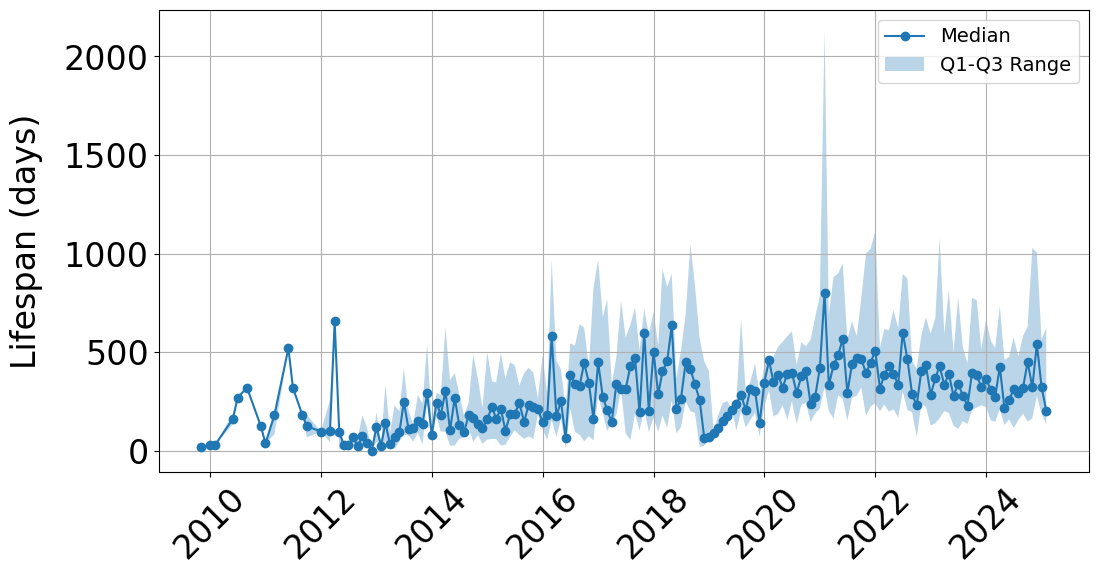

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def analyze_lifespan_evolution(df):
    """Analyzes the evolution of toggle lifespan over time on a monthly basis."""
    
    # Ensure 'lifecycle_days' is numeric
    df['lifecycle_days'] = pd.to_numeric(df['lifecycle_days'])
    df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], utc=True)

    # Drop invalid rows AFTER conversion (use .copy() to ensure a full copy)
    removed_toggles = df.dropna(subset=['commit_date_removed', 'lifecycle_days']).copy()

    # Now extract Year-Month safely
    removed_toggles['year_month'] = removed_toggles['commit_date_removed'].dt.to_period('M')
    
    if removed_toggles.empty:
        print("No valid toggle removal data available.")
        return pd.DataFrame()  # Return empty DataFrame if no data

    # Compute lifespan statistics per month
    lifespan_stats = removed_toggles.groupby(removed_toggles['year_month'])['lifecycle_days'].describe(percentiles=[0.25, 0.5, 0.75])

    # Convert index to datetime
    lifespan_stats.index = lifespan_stats.index.to_timestamp()

    return lifespan_stats


def plot_lifespan_evolution(lifespan_stats):
    """Plots the evolution of toggle lifespan over time showing median, average, min, max, Q1, and Q3."""
    fig = plt.figure(figsize=(12, 6))
    
    # Interpolate missing values to avoid plot gaps
    #lifespan_stats['50%'] = lifespan_stats['50%'].interpolate(method='linear')

    plt.plot(lifespan_stats.index, lifespan_stats['50%'], marker='o', linestyle='-', label='Median')
    plt.fill_between(lifespan_stats.index, lifespan_stats['25%'], lifespan_stats['75%'], alpha=0.3, label='Q1-Q3 Range')

    plt.xticks(rotation=45)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.ylabel("Lifespan (days)", fontsize=24, labelpad=15)
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(fontsize=24)

    plt.savefig('lifespan_evolution.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

lifespan_stats = analyze_lifespan_evolution(df)
print(lifespan_stats)
plot_lifespan_evolution(lifespan_stats)


/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_45231/3251684735.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  removed_toggles['year_month'] = removed_toggles['commit_date_removed'].dt.to_period("M")


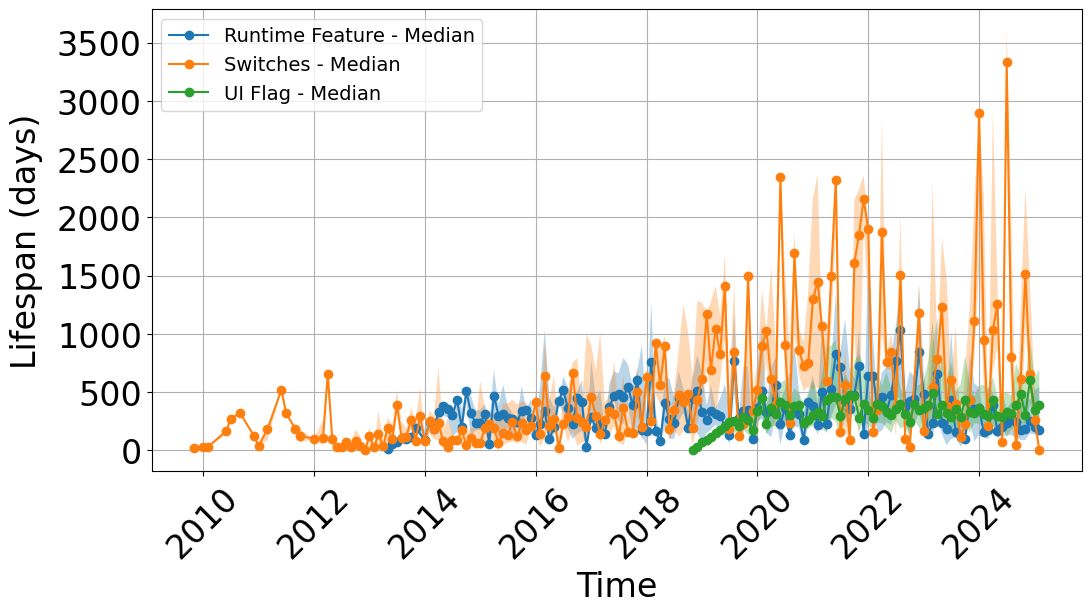

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_lifespan_evolution_by_type(df):
    """Analyzes the evolution of toggle lifespan over time on a monthly basis, grouped by toggle type."""
    
    # Ensure 'lifecycle_days' is numeric
    df['lifecycle_days'] = pd.to_numeric(df['lifecycle_days'], errors='coerce')
    
    # Convert commit_date_removed to datetime
    df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)
    
    # Drop rows with NaN values in critical columns
    removed_toggles = df.dropna(subset=['commit_date_removed', 'lifecycle_days', 'toggle_type']).copy()
    
    # Extract year-month for grouping
    removed_toggles['year_month'] = removed_toggles['commit_date_removed'].dt.to_period("M")
    
    # Compute lifespan statistics per month for each toggle type
    lifespan_stats_by_type = removed_toggles.groupby(['toggle_type', 'year_month'])['lifecycle_days'].describe(percentiles=[0.25, 0.5, 0.75])
    
    # Convert index to datetime for better plotting
    lifespan_stats_by_type = lifespan_stats_by_type.reset_index()
    lifespan_stats_by_type['commit_date_removed'] = lifespan_stats_by_type['year_month'].dt.to_timestamp()

    return lifespan_stats_by_type


def plot_lifespan_evolution_by_type(lifespan_stats_by_type):
    """Plots the evolution of toggle lifespan over time, showing median and Q1-Q3 range for each toggle type."""
    
    if lifespan_stats_by_type.empty:
        print("No data available for plotting.")
        return

    plt.figure(figsize=(12, 6))
    
    toggle_types = lifespan_stats_by_type['toggle_type'].unique()
    
    for toggle_type in toggle_types:
        data = lifespan_stats_by_type[lifespan_stats_by_type['toggle_type'] == toggle_type]
        
        # Plot median lifespan over time
        plt.plot(data['commit_date_removed'], data['50%'], marker='o', linestyle='-', label=f'{toggle_type} - Median')
        
        # Add Q1-Q3 range shading (Ensuring label appears once)
        plt.fill_between(data['commit_date_removed'], data['25%'], data['75%'], alpha=0.3)

    # Set x-axis format
    plt.xticks(rotation=45, fontsize=24)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True)
    plt.ylabel("Lifespan (days)", fontsize=24, labelpad=10)
    plt.xlabel("Time", fontsize=24)
    plt.yticks(fontsize=24)


    # Save and show the plot
    plt.savefig('lifespan_evolution_by_type.pdf', format='pdf', bbox_inches='tight')
    plt.show()


# Example usage
lifespan_stats_by_type = analyze_lifespan_evolution_by_type(df)
plot_lifespan_evolution_by_type(lifespan_stats_by_type)


In [6]:
import pandas as pd
from datetime import datetime

# Load your new status-changes data
status_changes = pd.read_csv("../../data/toggle_status_changes.csv", parse_dates=["date"])

status_changes['date'] = pd.to_datetime(status_changes['date'], errors='coerce', utc=True)

# 1. Get last time each toggle became stable (change_type == "add")
stable_adds = status_changes[
    (status_changes["status"] == "stable") &
    (status_changes["change_type"] == "add")
]

# 2. Get the latest stable date per toggle
last_stable = stable_adds.groupby("toggle")["date"].max().reset_index()
last_stable = last_stable.rename(columns={"toggle": "variable", "date": "date_stable"})

# 3. Merge with your main DataFrame df
df["commit_date_removed"] = pd.to_datetime(df["commit_date_removed"], errors="coerce", utc=True)
df_with_stable = df.merge(last_stable, on="variable", how="left")
df_with_stable["date_stable"] =pd.to_datetime(df_with_stable["date_stable"], errors="coerce", utc=True)

# 4. Compute delay between becoming stable and being removed
df_with_stable["stable_to_removed_days"] = (
    df_with_stable["commit_date_removed"] - df_with_stable["date_stable"]
).dt.days

# 5. Filter those that have both values (optional)
#result = df_with_stable[~df_with_stable["stable_to_removed_days"].isna()]

# 6. Show or export
#print(df_with_stable[["variable", "date_stable", "commit_date_removed", "lifecycle_days", "stable_to_removed_days"]])
rf=df_with_stable[df_with_stable['toggle_type'] == 'Runtime Feature']
rrf=rf[~rf['lifecycle_days'].isna()]

print(rrf[["variable", "date_stable", "commit_date_removed", "lifecycle_days", "stable_to_removed_days"]])


                       variable               date_stable  \
8             AOMAriaProperties 2020-01-30 01:13:19+00:00   
11                    AOMPhase1                       NaT   
12               AbortSignalAny 2023-06-06 16:30:18+00:00   
13       AbortSignalComposition 2023-03-10 06:49:02+00:00   
14    AbortSignalThrowIfAborted 2022-02-11 22:54:29+00:00   
...                         ...                       ...   
2646                       XSLT 2019-04-23 19:40:38+00:00   
2647   XYWHAndRectComputedValue 2023-09-15 14:38:00+00:00   
3366            checkVisibility 2022-06-30 18:41:29+00:00   
5811                  isVisible                       NaT   
9805                       smil 2017-03-28 01:48:20+00:00   

           commit_date_removed  lifecycle_days  stable_to_removed_days  
8    2022-04-15 12:02:10+00:00           903.0                   806.0  
11   2019-10-25 04:08:32+00:00            57.0                     NaN  
12   2024-01-12 00:05:13+00:00           370.0  

1767
701
count    1066.000000
mean      259.953096
std       268.794317
min         0.000000
25%        99.250000
50%       179.000000
75%       317.000000
max      2834.000000
Name: stable_to_removed_days, dtype: float64
179.0


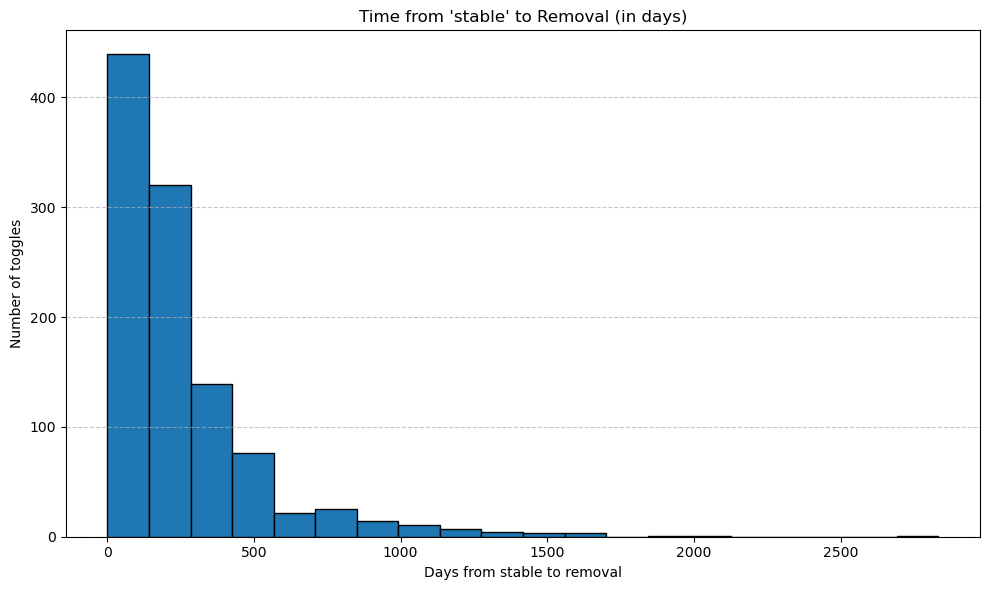

In [7]:
print(len(rrf))
print(len(rrf[rrf["stable_to_removed_days"].isna()]))

# Make sure to filter for valid durations (non-null and positive)
valid_durations = rrf["stable_to_removed_days"].dropna()
#valid_durations = valid_durations[valid_durations >= 0]

print(valid_durations.describe())

print(valid_durations.median())

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_durations, bins=20, edgecolor='black')
plt.title("Time from 'stable' to Removal (in days)")
plt.xlabel("Days from stable to removal")
plt.ylabel("Number of toggles")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_45231/3336371608.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['commit_date_removed'].dt.to_period('M')


            count        mean         std    min    25%    50%     75%     max
year_month                                                                    
2013-07-01    1.0   63.000000         NaN   63.0   63.0   63.0   63.00    63.0
2013-09-01    1.0  129.000000         NaN  129.0  129.0  129.0  129.00   129.0
2013-10-01    1.0    0.000000         NaN    0.0    0.0    0.0    0.00     0.0
2014-02-01   13.0  174.923077   97.972327    0.0  107.0  163.0  274.00   286.0
2014-03-01    2.0  157.000000  206.475180   11.0   84.0  157.0  230.00   303.0
...           ...         ...         ...    ...    ...    ...     ...     ...
2024-10-01   21.0  133.523810  106.744845   55.0   65.0   90.0  161.00   452.0
2024-11-01   37.0  273.864865  471.318491   12.0   83.0  119.0  272.00  2834.0
2024-12-01   14.0  160.000000   96.959944   48.0   77.5  146.0  236.75   311.0
2025-01-01   21.0  178.857143  124.882859    2.0  113.0  135.0  208.00   485.0
2025-02-01    7.0  106.571429   56.861988    1.0  10

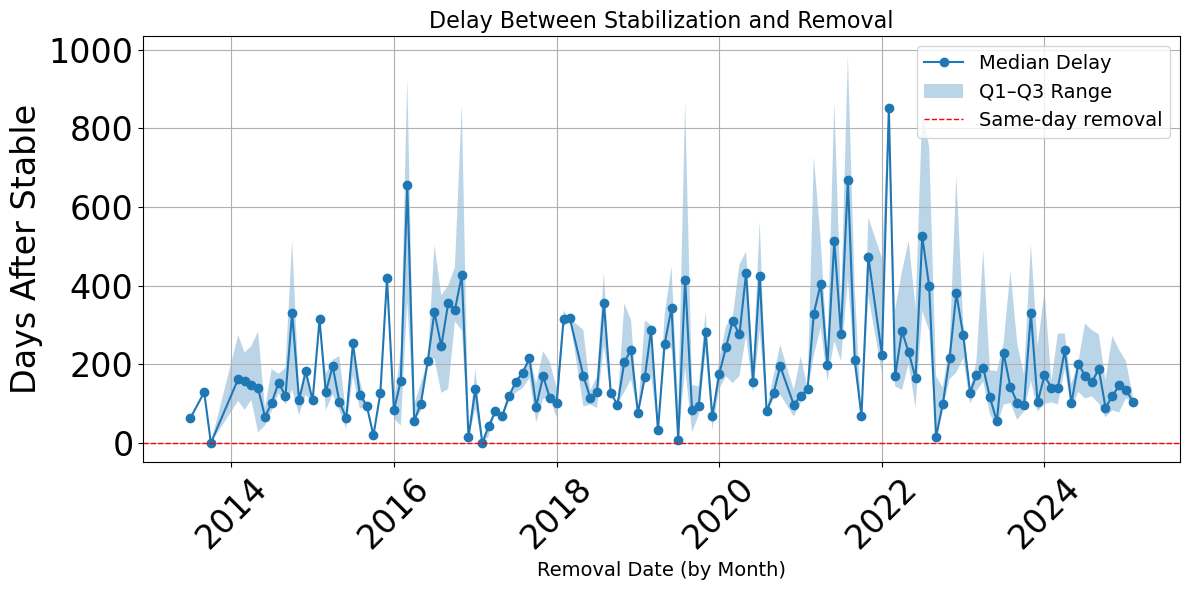

Median delay after October 2023: 158 days


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_stable_removal_delay(df):
    """Analyzes how long after becoming stable toggles are removed, monthly."""
    
    df = df.copy()

    # Ensure correct data types
    df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], utc=True)
    df['stable_to_removed_days'] = pd.to_numeric(df['stable_to_removed_days'], errors='coerce')

    # Drop rows with missing values
    df = df.dropna(subset=['commit_date_removed', 'stable_to_removed_days'])

    # Add Year-Month for aggregation
    df['year_month'] = df['commit_date_removed'].dt.to_period('M')

    if df.empty:
        print("No valid data to plot.")
        return pd.DataFrame()

    # Group by month and compute descriptive stats
    delay_stats = df.groupby('year_month')['stable_to_removed_days'].describe(percentiles=[0.25, 0.5, 0.75])
    delay_stats.index = delay_stats.index.to_timestamp()  # For plotting

    return delay_stats

def plot_stable_removal_delay(delay_stats):
    """Plots delay between 'stable' and removal date, monthly trend with median + IQR."""
    fig = plt.figure(figsize=(12, 6))

    plt.plot(delay_stats.index, delay_stats['50%'], marker='o', linestyle='-', label='Median Delay')
    plt.fill_between(delay_stats.index, delay_stats['25%'], delay_stats['75%'], alpha=0.3, label='Q1–Q3 Range')

    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Same-day removal')

    plt.title("Delay Between Stabilization and Removal", fontsize=16)
    plt.xlabel("Removal Date (by Month)", fontsize=14)
    plt.ylabel("Days After Stable", fontsize=24)
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig("stable_to_removal_trend.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
delay_stats = analyze_stable_removal_delay(rrf)
print(delay_stats)
plot_stable_removal_delay(delay_stats)

median_delay = rrf[rrf["commit_date_removed"] >= "2023-11-01"]["stable_to_removed_days"].median()
print(f"Median delay after October 2023: {median_delay:.0f} days")


In [18]:
import pandas as pd

# Load all required data
expiry_changes = pd.read_csv("../../data/expiry_milestone_changes.csv", parse_dates=["date"])
milestones = pd.read_csv("../../data/chromium_releases.csv", parse_dates=["Release Date"])
df =pd.read_csv('../../data/options_additions_removals.csv')

# Ensure datetime consistency
expiry_changes["date"] = pd.to_datetime(expiry_changes["date"], errors="coerce", utc=True)
milestones["Release Date"] = pd.to_datetime(milestones["Release Date"], errors="coerce", utc=True)
df["commit_date_removed"] = pd.to_datetime(df["commit_date_removed"], errors="coerce", utc=True)

# 1. Get the last expiry milestone assigned to each toggle (latest 'add')
last_expiry = expiry_changes[expiry_changes["change_type"] == "add"]
last_expiry = last_expiry.sort_values("date").groupby("toggle").last().reset_index()
last_expiry = last_expiry.rename(columns={"expiry_milestone": "last_expiry_milestone"})

# 2. For each milestone, get the earliest release date (across platforms)
milestone_dates = milestones.groupby("Milestone")["Release Date"].min().reset_index()

# 3. Calculate the milestone when the flag should be removed (expiry + 1)
last_expiry["remove_in_milestone"] = last_expiry["last_expiry_milestone"] + 1
last_expiry.loc[last_expiry["remove_in_milestone"] == 82, "remove_in_milestone"] = 83


# 4. Merge with milestone release dates to get expected removal date
milestone_dates = milestone_dates.rename(columns={
    "Milestone": "remove_in_milestone",
    "Release Date": "expected_removal_date"
})
last_expiry = last_expiry.merge(milestone_dates, on="remove_in_milestone", how="left")

# 5. Merge with your toggle lifecycle data (df)
merged = df.merge(last_expiry, left_on="variable", right_on="toggle", how="left")

# 6. Compute the delay (in days) between expected removal and actual removal
merged["days_after_expected_removal"] = (
    merged["commit_date_removed"] - merged["expected_removal_date"]
).dt.days

# 7. Select and clean relevant columns
result = merged[[
    "variable",
    "toggle_type",
    "last_expiry_milestone",
    "remove_in_milestone",
    "expected_removal_date",
    "commit_date_removed",
    "days_after_expected_removal"
]]

print(len(result))
result = result[(result['toggle_type'] == 'UI Flag') & (result["commit_date_removed"].notna()) & (result['remove_in_milestone'] <=120)]

result = result.dropna(subset=["commit_date_removed"])

print(len(result))
# 8. Show or export results


print(result["days_after_expected_removal"].describe())
print(result[result['days_after_expected_removal'] > 0 ].describe())

#print(result['days_after_expected_removal'].describe())
# result.to_csv("toggle_expiry_vs_actual_removal.csv", index=False)


10412
2468
count    2468.000000
mean       29.933144
std       261.598556
min      -455.000000
25%      -126.000000
50%       -42.000000
75%       112.000000
max      1827.000000
Name: days_after_expected_removal, dtype: float64
       last_expiry_milestone  remove_in_milestone  days_after_expected_removal
count             936.000000           936.000000                   936.000000
mean               93.280983            94.289530                   274.571581
std                13.099092            13.091392                   268.392412
min                71.000000            72.000000                     1.000000
25%                82.000000            83.000000                    71.000000
50%                92.000000            93.000000                   177.500000
75%               104.000000           105.000000                   396.000000
max               119.000000           120.000000                  1827.000000


2468
            count         mean         std    min     25%    50%      75%  \
year_month                                                                  
2018-11-01    9.0  -293.666667    1.870829 -295.0 -295.00 -294.0  -294.00   
2018-12-01   19.0  -256.736842   43.315178 -281.0 -278.50 -267.0  -263.00   
2019-01-01   21.0  -201.476190   54.634805 -245.0 -230.00 -229.0  -223.00   
2019-02-01  102.0  -205.460784   30.573616 -299.0 -215.00 -210.0  -207.00   
2019-03-01   56.0  -177.160714   35.719502 -340.0 -187.00 -183.0  -168.75   
...           ...          ...         ...    ...     ...    ...      ...   
2024-10-01   11.0   592.727273  280.525254  321.0  408.50  448.0   765.00   
2024-11-01    6.0   737.833333  224.105704  461.0  555.25  770.5   908.50   
2024-12-01    3.0  1097.666667  673.921608  498.0  733.00  968.0  1397.50   
2025-01-01    5.0   725.800000  479.854874  408.0  463.00  496.0   701.00   
2025-02-01    1.0   834.000000         NaN  834.0  834.00  834.0   834.

/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_45231/1824739423.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['commit_date_removed'].dt.to_period('M')


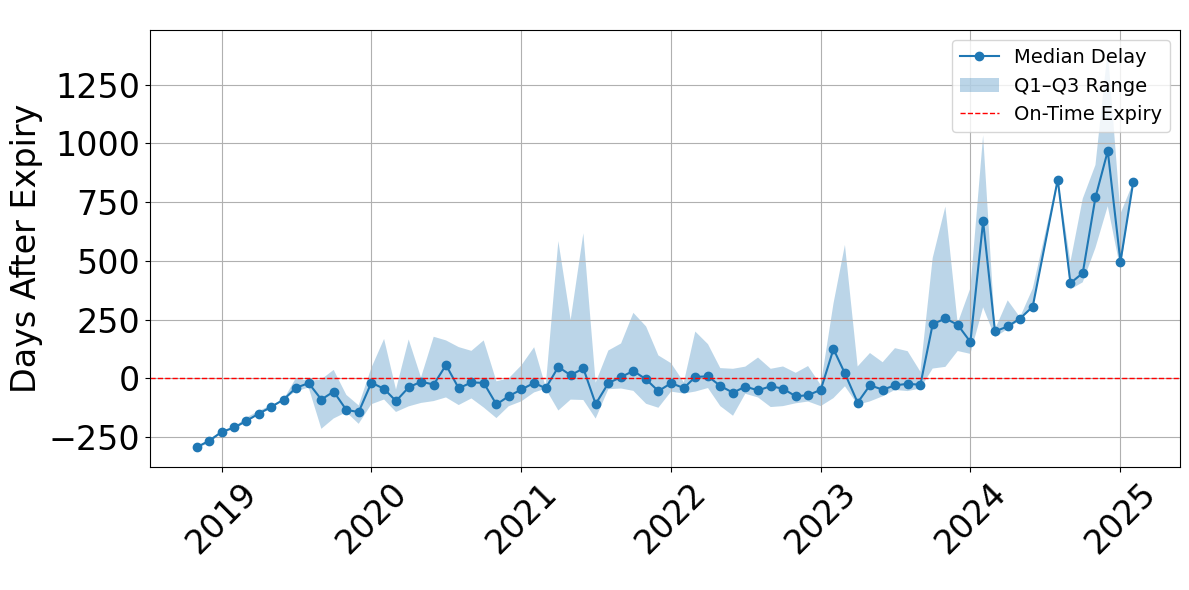

Median delay after October 2023: 370 days


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_expiry_removal_delay(df):
    """Analyzes how long after the expected expiry date toggles are removed, monthly."""
    
    df = df.copy()

    # Ensure required columns are proper types
    df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], utc=True)
    df['days_after_expected_removal'] = pd.to_numeric(df['days_after_expected_removal'], errors='coerce')

    # Drop rows with missing removal dates or days difference
    df = df.dropna(subset=['commit_date_removed', 'days_after_expected_removal'])

    # Add Year-Month column
    df['year_month'] = df['commit_date_removed'].dt.to_period('M')

    if df.empty:
        print("No valid data to plot.")
        return pd.DataFrame()

    # Group by month and compute percentiles
    delay_stats = df.groupby('year_month')['days_after_expected_removal'].describe(percentiles=[0.25, 0.5, 0.75])
    delay_stats.index = delay_stats.index.to_timestamp()  # Convert to datetime index

    return delay_stats

def plot_expiry_removal_delay(delay_stats):
    """Plots the monthly trend of delays between expiry and actual toggle removal."""
    fig = plt.figure(figsize=(12, 6))

    plt.plot(delay_stats.index, delay_stats['50%'], marker='o', linestyle='-', label='Median Delay')
    plt.fill_between(delay_stats.index, delay_stats['25%'], delay_stats['75%'], alpha=0.3, label='Q1–Q3 Range')

    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='On-Time Expiry')

    plt.title(" ")
    plt.xlabel(" ")
    plt.ylabel("Days After Expiry", fontsize=24)
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=14)

    plt.tight_layout()
    plt.savefig('expiry_to_removal_trend.pdf', format='pdf', bbox_inches='tight')
    plt.show()

print(len(result))
# Run the analysis and plot
delay_stats = analyze_expiry_removal_delay(result)
print(delay_stats)
plot_expiry_removal_delay(delay_stats)

median_delay = result[result["commit_date_removed"] >= "2023-11-01"]["days_after_expected_removal"].median()
print(f"Median delay after October 2023: {median_delay:.0f} days")


In [11]:
import pandas as pd

# Load data
expiry_changes = pd.read_csv("../../data/expiry_milestone_changes.csv")

# Filter to 'add' only (because these represent new assigned expiry milestones)
expiry_adds = expiry_changes[expiry_changes["change_type"] == "add"]

# Count how many unique expiry_milestone values each toggle had
milestone_counts = expiry_adds.groupby("toggle")["expiry_milestone"].nunique().reset_index()
milestone_counts = milestone_counts.rename(columns={"expiry_milestone": "unique_expiry_count"})

print(milestone_counts)
# How many toggles had their expiry milestone changed more than once?
num_with_changes = (milestone_counts["unique_expiry_count"] > 1).sum()
total_toggles = milestone_counts.shape[0]

print(milestone_counts[milestone_counts["unique_expiry_count"] > 1].describe())

print(f"{num_with_changes} out of {total_toggles} toggles had their expiry milestone delayed at least once.")


                          toggle  unique_expiry_count
0        3p-intents-in-incognito                    2
1       AffiliationBasedMatching                    1
2          BundledConnectionHelp                    1
3                            CCO                    2
4            ChromeVoxArcSupport                    1
...                          ...                  ...
5132                  xr-sandbox                    3
5133  xsurface-metrics-reporting                    3
5134       zero-copy-tab-capture                    5
5135     zero-copy-video-capture                    9
5136            zero-state-files                    1

[5137 rows x 2 columns]
       unique_expiry_count
count          2406.000000
mean              3.111804
std               1.666463
min               2.000000
25%               2.000000
50%               2.000000
75%               4.000000
max              16.000000
2406 out of 5137 toggles had their expiry milestone delayed at least once.


In [12]:
import pandas as pd

# Load data
expiry_changes = pd.read_csv("../../data/expiry_milestone_changes.csv")

# Filter to 'add' events only
expiry_adds = expiry_changes[expiry_changes["change_type"] == "add"]

# Count unique expiry milestones per toggle
milestone_counts = expiry_adds.groupby("toggle")["expiry_milestone"].nunique().reset_index()
milestone_counts = milestone_counts.rename(columns={"expiry_milestone": "unique_expiry_count"})

# Keep only toggles where expiry was changed (more than one unique value)
toggles_with_changes = milestone_counts[milestone_counts["unique_expiry_count"] > 1]

# Get min and max expiry_milestone per toggle
expiry_range = expiry_adds.groupby("toggle")["expiry_milestone"].agg(["min", "max"]).reset_index()
expiry_range["milestone_range"] = expiry_range["max"] - expiry_range["min"]

# Merge only for toggles with expiry changes
result = toggles_with_changes.merge(expiry_range, on="toggle")

# Output
print(result.sort_values("milestone_range", ascending=False).head())
print()
print("Summary of milestone extension ranges:")
print(result["milestone_range"].describe())

print(result[result["milestone_range"] == 9])


                                 toggle  unique_expiry_count  min  max  \
688   enable-cros-hindi-inscript-layout                    2  117  250   
2142                   smooth-scrolling                    5   76  160   
1083            enable-tls13-early-data                    5   83  160   
450                crostini-gpu-support                    6   78  150   
1683            omnibox-max-url-matches                    8   80  150   

      milestone_range  
688               133  
2142               84  
1083               77  
450                72  
1683               70  

Summary of milestone extension ranges:
count    2406.000000
mean       12.454281
std        12.499654
min         1.000000
25%         5.000000
50%         9.000000
75%        15.000000
max       133.000000
Name: milestone_range, dtype: float64
                                           toggle  unique_expiry_count  min  \
53                                      app-cache                    4   86   
88     

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

df =pd.read_csv('../../data/options_additions_removals.csv')
df = df[df['toggle_type'] == 'Runtime Feature']

status_changes = pd.read_csv("../../data/toggle_status_changes.csv")

print(df.head())
print('-----')
print(status_changes.head())




   Unnamed: 0                    variable      toggle_type  \
1           1                 AIPromptAPI  Runtime Feature   
2           2     AIPromptAPIForExtension  Runtime Feature   
3           3   AIPromptAPIForWebPlatform  Runtime Feature   
4           4  AIPromptAPIMultimodalInput  Runtime Feature   
5           5               AIRewriterAPI  Runtime Feature   

           commit_date_added                           commit_id_added  \
1  2024-07-19 03:53:27+00:00  3dbfb8a9f6f03d39e52b3ae3eeca8fa169a70d28   
2  2024-09-26 08:13:47+00:00  87e7b24e86a2b2310ce2f0afab9e1223fec894cc   
3  2024-09-26 08:13:47+00:00  87e7b24e86a2b2310ce2f0afab9e1223fec894cc   
4  2025-01-30 23:38:08-08:00  b2c6aaedc26cec4c4a9fdf90a03fee64af5917a1   
5  2024-08-15 07:57:29+00:00  2e2bb01ac8c5bf91d61e10777deeb5dc2e32d862   

                                commit_message_added commit_date_removed  \
1  Author: Jiacheng Guo <gjc@google.com> Decouple...                 NaN   
2  Author: Lei Mingyu <leimy@c

In [14]:
import pandas as pd

# Load data
df = pd.read_csv('../../data/options_additions_removals.csv')
df = df[(df['toggle_type'] == 'Runtime Feature') & (~df['commit_date_removed'].isna())]
print(len(df))

status_changes = pd.read_csv("../../data/toggle_status_changes.csv")
status_changes["date"] = pd.to_datetime(status_changes["date"], errors="coerce", utc=True)

# Filter stable add events
stable_adds = status_changes[
    (status_changes["status"] == "stable") &
    (status_changes["change_type"] == "add")
]

# Get the first date each toggle became stable
first_stable = stable_adds.groupby("toggle")["date"].min().reset_index()
first_stable = first_stable.rename(columns={"toggle": "variable", "date": "date_stable"})

# Merge with df to get the addition date
df["commit_date_added"] = pd.to_datetime(df["commit_date_added"], errors="coerce", utc=True)
df_with_stable = df.merge(first_stable, on="variable", how="left")

# Compute delay in days from addition → stable
df_with_stable["days_to_stable"] = (
    df_with_stable["date_stable"] - df_with_stable["commit_date_added"]
).dt.days

# Preview the result
print(df_with_stable[["variable", "commit_date_added", "date_stable", "days_to_stable"]].dropna().sort_values("days_to_stable", ascending=False))

# Summary stats
print("\nSummary:")
print(len(df_with_stable[df_with_stable["days_to_stable"].isna()]))
print(len(df_with_stable[df_with_stable["days_to_stable"]==0]))
print(df_with_stable[df_with_stable["days_to_stable"]==0])

print(len(df_with_stable[df_with_stable["days_to_stable"]>0]))
print(df_with_stable[df_with_stable["days_to_stable"]>0].describe())


1767
                               variable         commit_date_added  \
201   CSSIndependentTransformProperties 2015-06-22 02:27:43+00:00   
247             CSSOffsetPositionAnchor 2016-09-22 02:19:11+00:00   
1644                   WebAnimationsAPI 2013-11-25 07:11:36+00:00   
244                    CSSOffsetPathRay 2017-05-16 02:30:18+00:00   
245             CSSOffsetPathRayContain 2017-05-16 02:30:18+00:00   
...                                 ...                       ...   
816                   InputClipRulesCss 2024-05-30 12:31:02+00:00   
822     InputStepCurrentValueValidation 2024-04-23 22:49:35+00:00   
1369           ScrollableAreaNoSnapping 2023-06-05 05:57:29+00:00   
823                      InputTypeColor 2013-06-05 15:34:48+00:00   
1766                               smil 2015-07-27 07:51:01+00:00   

                   date_stable  days_to_stable  
201  2022-06-06 22:56:40+00:00          2541.0  
247  2023-06-20 11:22:16+00:00          2462.0  
1644 2020-04-27 18:

In [ ]:
import pandas as pd

# Load data
expiry_changes = pd.read_csv("../../data/expiry_milestone_changes.csv", parse_dates=["date"])
milestones = pd.read_csv("../../data/chromium_releases.csv", parse_dates=["Release Date"])
df = pd.read_csv('../../data/options_additions_removals.csv', parse_dates=["commit_date_added"])

# Step 1: Get the first expiry_milestone assigned when a toggle was added
expiry_adds = expiry_changes[expiry_changes["change_type"] == "add"]
first_expiry = expiry_adds.sort_values("date").groupby("toggle").first().reset_index()
first_expiry = first_expiry.rename(columns={"toggle": "variable", "expiry_milestone": "initial_expiry_milestone"})

# Step 2: Merge with toggle metadata to match the added toggles
df_expiry = df.merge(first_expiry, on="variable", how="left")

# Step 3: Increment milestone by 1 to get the actual removal milestone
df_expiry["removal_milestone"] = df_expiry["initial_expiry_milestone"] + 1

# Step 4: Get release dates for each milestone (group by milestone to get earliest release per milestone)
milestone_dates = milestones.groupby("Milestone")["Release Date"].min().reset_index()
milestone_dates = milestone_dates.rename(columns={
    "Milestone": "removal_milestone",
    "Release Date": "expected_removal_date"
})

# Step 5: Merge to get expected removal date
df_expiry = df_expiry.merge(milestone_dates, on="removal_milestone", how="left")

# Step 6: Compute the "intended" toggle lifespan in days
df_expiry["commit_date_added"] = pd.to_datetime(df_expiry["commit_date_added"], errors="coerce", utc=True)
df_expiry["expected_removal_date"] = pd.to_datetime(df_expiry["expected_removal_date"], errors="coerce", utc=True)

df_expiry["intended_lifespan_days"] = (
    df_expiry["expected_removal_date"] - df_expiry["commit_date_added"]
).dt.days

# Step 7: Select and clean result
result = df_expiry[[
    "variable",
    "commit_date_added",
    "initial_expiry_milestone",
    "removal_milestone",
    "expected_removal_date",
    "intended_lifespan_days"
]].dropna()

# Preview the shortest lifespans
print(result.sort_values("intended_lifespan_days", ascending=True).head())

# Summary stats
print("\nSummary of Intended Lifespan (Days):")
print(result[result["intended_lifespan_days"]>0].describe())


                                  variable         commit_date_added  \
9323                  private-state-tokens 2022-11-18 20:11:55+00:00   
9629                     send-uma-cellular 2020-03-10 17:36:27+00:00   
3440   collections-card-presentation-style 2020-03-10 17:36:27+00:00   
5407                   find-in-page-iframe 2020-03-10 17:36:27+00:00   
10317              web-clear-browsing-data 2020-03-10 17:36:27+00:00   

       initial_expiry_milestone  removal_milestone     expected_removal_date  \
9323                      105.0              106.0 2022-09-27 13:14:44+00:00   
9629                       80.0               81.0 2020-04-07 14:00:00+00:00   
3440                       80.0               81.0 2020-04-07 14:00:00+00:00   
5407                       80.0               81.0 2020-04-07 14:00:00+00:00   
10317                      80.0               81.0 2020-04-07 14:00:00+00:00   

       intended_lifespan_days  
9323                    -53.0  
9629                  